In [2]:
import joblib

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from typing import List, NamedTuple
import sys

sys.path.append("./")
sys.path.append("../..")
from models.tabnet_proba import TabNetRegressorProba

import os
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from collections import defaultdict

In [3]:
input_cols = [
    "gen_other",
    "gen_solar",
    "gen_wind_on",
    "gen_waste",
    "gen_nuclear",
    "gen_biomass",
    "gen_gas",
    "gen_run_off_hydro",
    "gen_oil",
    "gen_pumped_hydro",
    "gen_other_renew",
    "gen_reservoir_hydro",
    "gen_hard_coal",
    "gen_wind_off",
    "gen_geothermal",
    "gen_lignite",
    "load",
    "gen_coal_gas",
    "total_gen",
    "synchronous_gen",
    "load_ramp",
    "total_gen_ramp",
    "other_ramp",
    "solar_ramp",
    "wind_on_ramp",
    "waste_ramp",
    "nuclear_ramp",
    "biomass_ramp",
    "gas_ramp",
    "run_off_hydro_ramp",
    "oil_ramp",
    "pumped_hydro_ramp",
    "other_renew_ramp",
    "reservoir_hydro_ramp",
    "hard_coal_ramp",
    "wind_off_ramp",
    "geothermal_ramp",
    "lignite_ramp",
    "coal_gas_ramp",
    "forecast_error_wind_on",
    "forecast_error_wind_off",
    "forecast_error_solar",
    "forecast_error_total_gen",
    "forecast_error_load",
    "forecast_error_load_ramp",
    "forecast_error_total_gen_ramp",
    "forecast_error_wind_off_ramp",
    "forecast_error_wind_on_ramp",
    "forecast_error_solar_ramp",
    "solar_day_ahead",
    "wind_on_day_ahead",
    "scheduled_gen_total",
    "prices_day_ahead",
    "load_day_ahead",
    "wind_off_day_ahead",
    "month",
    "weekday",
    "hour",
    "load_ramp_day_ahead",
    "total_gen_ramp_day_ahead",
    "wind_off_ramp_day_ahead",
    "wind_on_ramp_day_ahead",
    "solar_ramp_day_ahead",
    "price_ramp_day_ahead",
    "gen_fossil_peat",
    "fossil_peat_ramp",
    "residual",
]


input_col_names = [
    "Generation other",
    "Solar generation",
    "Onshore wind generation",
    "Waste generation",
    "Nuclear generation",
    "Biomass generation",
    "Gas generation",
    "Run-off-river hydro generation",
    "Oil generation",
    "Pumped hydro generation",
    "Other renewable generation",
    "Reservoir hydro generation",
    "Hard coal generation",
    "Wind offshore generation",
    "Geothermal generation",
    "Lignite generation",
    "Load",
    "Coal gas generation",
    "Total generation",
    "Synchronous generation",
    "Load ramp",
    "Total generation ramp",
    "Other ramp",
    "Solar ramp",
    "Onshore wind ramp",
    "Waste ramp",
    "Nuclear ramp",
    "Biomass ramp",
    "Gas ramp",
    "Run-off-river hydro ramp",
    "Oil ramp",
    "Pumped hydro ramp",
    "Other renewable ramp",
    "Reservoir hydro ramp",
    "Hard coal ramp",
    "Offshore wind ramp",
    "geothermal_ramp",
    "Lignite ramp",
    "Coal gas ramp",
    "Forecast error onshore wind",
    "Forecast error offshore wind",
    "Forecast error solar",
    "Forecast error total generation",
    "Forecast error load",
    "Forecast error load ramp",
    "Forecast error generation ramp",
    "Forecast error offshore wind ramp",
    "Forecast error onshore wind ramp",
    "Forecast error solar ramp",
    "Solar day-ahead",
    "Onshore wind day-ahead",
    "Scheduled generation",
    "Prices day-ahead",
    "Load day-ahead",
    "Offshore wind day-ahead",
    "Month",
    "Weekday",
    "Hour",
    "Load ramp day-ahead",
    "Generation ramp day-ahead",
    "Offshore wind ramp day-ahead",
    "Onshore wind ramp day-ahead",
    "Solar ramp day-ahead",
    "Price ramp day-ahead",
    "Fossil peat generation",
    "Fossil peat ramp",
    "Residual",
]

input_col_names = dict(zip(input_cols, input_col_names))
#input_col_names_units = dict(zip(input_cols, input_col_names_units))
#input_col_names_units_general = dict(zip(input_cols, input_col_names_units_general))

input_rescale_factors = pd.Series(index=input_cols, data=1 / 1000)
input_rescale_factors.loc[
    ["weekday", "hour", "month", "prices_day_ahead", "price_ramp_day_ahead"]
] = 1


In [4]:
class Config(NamedTuple):
    data_version: str = "2024-05-19"
    res_version: str = "2024-06-24"
    model_type: str = "_full"
    model_combination: str = "ngb"
    model_name: str = "NGBoost"
    predictors_prob: List[str] = ["baseline", "predictions"]
    model_names_prob: List[str] =["Baseline", "NGBoost (full model)"],
    model_names_det: List[str] =["Daily profile", "NGBoost (full model)"],    
    predictors_det: List[str] = ["daily_profile", "predictions"]
    scaler_str: str = "yeo_johnson"
    scaled: str = "_scaled"
    explanations: str ="_partition" # for tabnet proba it can be "_partition" because of the two explainers

config_ngb = Config()

config_tabnet_proba = Config(
    res_version="2024-08-27",
    model_combination="tabnet_proba_final",
    model_name = "TabnetProba",
    model_names_det=["Daily profile", "TabNetProba"],
    explanations="_partition"
)

In [5]:
data_folder = "../data/2020-2024/{}/version_{}/yeo_johnson/"
explain_folder = "../explanations/{}/version_{}_{}/target_{}/explanations{}/"
fit_folder = "../results/model_fit/{}/version_{}_{}"+ "/{}/" + "target_{}/"

scaled_str = "_scaled"

In [6]:
area_names = ["Continental Europe", "Nordic"]
area_colors = ["C0", "C1"]
model_colors = ['#DF9B1B', '#009682', '#4664AA', '#8CB6C3',   '#A22223', '#20b2aa']

In [34]:
area = "CE"
target = "f_rocof"

X_train = pd.read_hdf(data_folder.format(area, config_ngb.data_version) + "X_train_full_scaled.h5")
X_test = pd.read_hdf(data_folder.format(area, config_ngb.data_version) + "X_test_full_scaled.h5")
y_test = pd.read_hdf(data_folder.format(area, config_ngb.data_version)+ f"y_test{config_ngb.scaled}.h5").loc[:, target]
y_pred = pd.read_hdf(fit_folder.format(area, config_ngb.res_version, config_ngb.model_combination, config_ngb.scaler_str, target) + "y_pred.h5")
ngb_model = joblib.load(fit_folder.format(area, config_ngb.res_version, config_ngb.model_combination, config_ngb.scaler_str, target) + "best_ngb_model.pkl")

In [23]:
y_pred_ngb = ngb_model.pred_dist(X_test)
y_pred_mean = y_pred["predictions"]
y_pred_std = y_pred_ngb.scale
y_true = y_test.values

/home/kit/iai/wy8179/.conda/envs/patterns4/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/home/kit/iai/wy8179/.conda/envs/patterns4/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/home/kit/iai/wy8179/.conda/envs/patterns4/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/home/kit/iai/wy8179/.conda/envs/patterns4/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Figure saved at ../../results/figures/comparison_plots/calibration_curve_CE.pdf


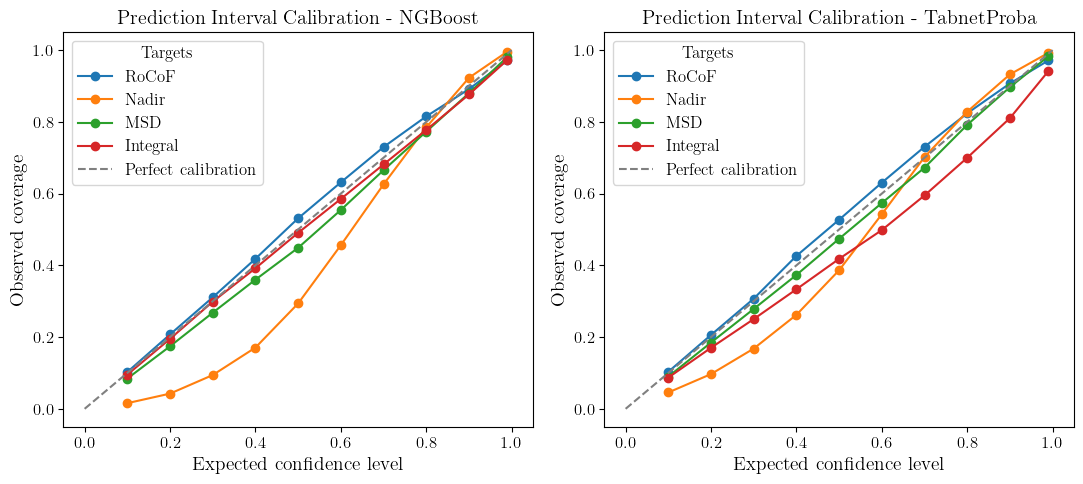

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import joblib
import pandas as pd
from scipy.stats import norm

def plot_calibration_curves(area, save: bool):
    """
    Function to plot calibration curves for different areas and targets based on the provided config.
    
    Args:
    - config: An object containing necessary configurations such as data folder paths, 
              list of areas, targets, and other model-related settings.
    """
    plt.rcParams['text.usetex'] = True
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 12

    areas = ["CE", "Nordic"]
    targets = ["f_rocof", "f_ext", "f_msd", "f_integral"]

    target_mappings = {
        "f_rocof": "RoCoF",
        "f_ext": "Nadir",
        "f_msd": "MSD",
        "f_integral": "Integral"
    }

    confidence_levels = np.arange(0.1, 1.0, 0.1).tolist() + [0.99]  
    z_values = [norm.ppf((1 + level) / 2) for level in confidence_levels]  
    fig, axes = plt.subplots(1, 2, figsize=(11, 5))
    axes = dict(zip(["NGBoost", "TabnetProba"], axes))  

    for config in [config_ngb, config_tabnet_proba]:
        for target in targets:
            X_test = pd.read_hdf(data_folder.format(area, config.data_version) + "X_test_full_scaled.h5")
            y_test = pd.read_hdf(data_folder.format(area, config.data_version) + f"y_test{config.scaled}.h5").loc[:, target]
            y_pred = pd.read_hdf(fit_folder.format(area, config.res_version, config.model_combination, config.scaler_str, target) + "y_pred.h5")
            if config.model_name == "NGBoost":

                ngb_model = joblib.load(fit_folder.format(area, config.res_version, config.model_combination, config.scaler_str, target) + "best_ngb_model.pkl")

                y_pred_ngb = ngb_model.pred_dist(X_test)
                y_pred_mean = y_pred["predictions"]
                y_pred_std = y_pred_ngb.scale
            elif config.model_name == "TabnetProba":
                model = TabNetRegressorProba()
                model.load_model(fit_folder.format(area, config.res_version, config.model_combination, config.scaler_str, target) + "best_model_params.zip")
                y_pred_tabnet = model.predict(X_test.values)
                y_pred_mean = y_pred_tabnet[:, 0]
                y_pred_std = np.sqrt(y_pred_tabnet[:, 1]) + 1e-6
            
            y_true = y_test.values

            observed_coverage = []

            for z in z_values:
                lower_bounds = y_pred_mean - z * y_pred_std
                upper_bounds = y_pred_mean + z * y_pred_std
                within_interval = np.logical_and(y_true >= lower_bounds, y_true <= upper_bounds)
                observed_coverage.append(np.mean(within_interval))

            axes[config.model_name].plot(confidence_levels, observed_coverage, marker='o', label=target_mappings[target])

        axes[config.model_name].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect calibration')
        axes[config.model_name].set_xlabel('Expected confidence level', fontsize=14)
        axes[config.model_name].set_ylabel('Observed coverage', fontsize=14)
        axes[config.model_name].set_title(f'Prediction Interval Calibration - {config.model_name}')
        axes[config.model_name].legend(title="Targets", fontsize=12)

    plt.tight_layout()
    if save:
        figpath_name = f"../../results/figures/comparison_plots/calibration_curve_{area}.pdf"
        plt.savefig(figpath_name, bbox_inches='tight')  # Save the figure
        print(f"Figure saved at {figpath_name}")
        plt.show()
    else:
        plt.show()

plot_calibration_curves("CE", save=True)



Interpretation of the Results:
* Well-calibrated: The true values fall within the intervals 
   close to the expected percentage (e.g., 90% for a 90% interval).
* Underconfident: If the observed coverage is higher than expected, 
   the intervals are too wide, indicating that the model is overestimating uncertainty.
* Overconfident: If the observed coverage is lower than expected, the intervals 
   are too narrow, indicating that the model is underestimating uncertainty.

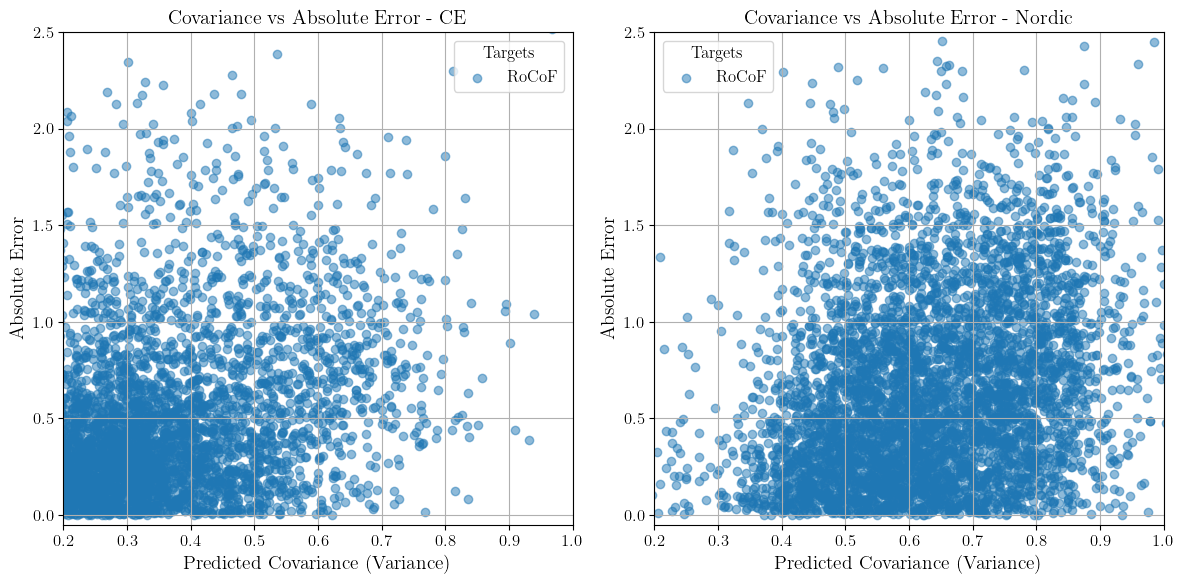

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import joblib
import pandas as pd

def plot_covariance_vs_error(config, target):
    """
    Function to plot scatter plots of predicted covariance (variance) vs absolute error 
    for different areas and targets based on the provided config.

    Args:
    - config: An object containing necessary configurations such as data folder paths, 
              list of areas, targets, and other model-related settings.
    """
    plt.rcParams['text.usetex'] = True
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 12

    # Define the areas and targets
    areas = ["CE", "Nordic"]
    targets = ["f_rocof"
               #, "f_ext", "f_msd", "f_integral"
               ]

    # Map target names to legend labels
    target_mappings = {
        "f_rocof": "RoCoF",
        "f_ext": "Nadir",
        "f_msd": "MSD",
        "f_integral": "Integral"
    }

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes = dict(zip(areas, axes))  # Map each area to its corresponding axis

    # Loop through each area (CE, Nordic)
    for area in areas:
        # Loop through each target
            # Load the data
        X_test = pd.read_hdf(data_folder.format(area, config.data_version) + "X_test_full_scaled.h5")
        y_test = pd.read_hdf(data_folder.format(area, config.data_version) + f"y_test{config.scaled}.h5").loc[:, target]
        y_pred = pd.read_hdf(fit_folder.format(area, config.res_version, config.model_combination, config.scaler_str, target) + "y_pred.h5")

        if config.model_name == "NGBoost":
            ngb_model = joblib.load(fit_folder.format(area, config.res_version, config.model_combination, config.scaler_str, target) + "best_ngb_model.pkl")
            y_pred_ngb = ngb_model.pred_dist(X_test)
            y_pred_mean = y_pred["predictions"]
            y_pred_std = y_pred_ngb.scale
        elif config.model_name == "TabnetProba":
            model = TabNetRegressorProba()
            model.load_model(fit_folder.format(area, config.res_version, config.model_combination, config.scaler_str, target) + "best_model_params.zip")
            y_pred_tabnet = model.predict(X_test.values)
            y_pred_mean = y_pred_tabnet[:, 0]
            y_pred_std = np.sqrt(y_pred_tabnet[:, 1]) + 1e-6  # Predicted standard deviation

        y_true = y_test.values

        # Calculate absolute errors and predicted covariance (variance)
        absolute_errors = np.abs(y_true - y_pred_mean)
        predicted_covariance = y_pred_std ** 2  # Covariance is variance

        # Scatter plot of covariance vs absolute error
        axes[area].scatter(predicted_covariance, absolute_errors, alpha=0.5, label=target_mappings[target])

        # Add details to the plot for the area
        axes[area].set_xlabel('Predicted Covariance (Variance)', fontsize=14)
        axes[area].set_ylabel('Absolute Error', fontsize=14)
        axes[area].set_title(f'Covariance vs Absolute Error - {area}')
        axes[area].legend(title="Targets", fontsize=12)
        axes[area].grid(True)
        axes[area].set_xlim(0.2,1)
        axes[area].set_ylim(-0.05,2.5)
    #plt.xlim(0, 2.5) 
    plt.tight_layout()
    plt.show()

# Example usage:
plot_covariance_vs_error(config_ngb, "f_rocof")
